In [9]:
import mnist_reader
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

class Data(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index,:], self.y[index]
   
    def __len__(self):
        return self.len

def label_name(label):
    mapping = {
                0: "T-shirt/Top",
                1: "Trouser",
                2: "Pullover",
                3: "Dress",
                4: "Coat", 
                5: "Sandal", 
                6: "Shirt",
                7: "Sneaker",
                8: "Bag",
                9: "Ankle Boot"
            }
    return mapping[label]


X_train1, y_train1 = mnist_reader.load_mnist('', kind='train')
X_train = torch.from_numpy(X_train1).float()
y_train = torch.from_numpy(y_train1).float()
X_test1, y_test1 = mnist_reader.load_mnist('', kind='t10k')
X_test = torch.from_numpy(X_test1).float()
y_test = torch.from_numpy(y_test1).float()

train_data = Data(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=100)
test_data = Data(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=100)

In [10]:
import torch
from torch import nn
import numpy as np

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Unflatten(1, torch.Size([1, 28, 28])),
            #Conv1
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Tanh(),
            #Pool1
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            #Conv2
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Tanh(),
            #Pool2
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=5*5*16, out_features=120, bias=True),

            nn.Linear(in_features=120, out_features=84, bias=True),

            nn.Linear(in_features=84, out_features=10, bias=True),
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = torch.flatten(x, 1)
        x = nn.functional.softmax(self.linear_layers(x), dim=1)
        
        return x

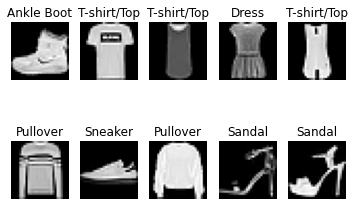

In [11]:
from matplotlib import pyplot as plt

tempx, tempy = train_data[:10]
rows, cols = 2, 5

figure, axis = plt.subplots(rows, cols)
img = 0

for i in range(rows):
    for j in range(cols):
        axis[i, j].imshow(tempx[img].reshape(28, 28, 1), cmap="gray")
        axis[i, j].set_title(label_name(tempy[img].item()))
        axis[i, j].axis('off')
        img += 1

plt.show()

In [12]:
from torch import optim

model = NeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

epoch = 25

train_loss = []
train_acc = []
epoch_list = []
train_correct_list = []
train_total_list = []
val_correct_list = []
val_total_list = []

for e in range(epoch):
    
    train_running_loss = 0
    train_total = 0
    train_correct = 0

    for x, y in train_loader:
        preds = model(x)
        loss = criterion(preds, y.long())
        train_running_loss += loss.item()
        train_total += len(preds)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds_label = torch.max(preds, 1)[1]
        train_correct += (y == preds_label).sum()
        #train_correct_list.append(train_correct.item())
        #train_total_list.append(train_total)

    train_loss.append(train_running_loss/train_total)
    train_acc.append(train_correct / train_total * 100)

    epoch_list.append(e)
    print(f"Epoch {e} done")


Epoch 0 done
Epoch 1 done
Epoch 2 done
Epoch 3 done
Epoch 4 done
Epoch 5 done
Epoch 6 done
Epoch 7 done
Epoch 8 done
Epoch 9 done
Epoch 10 done
Epoch 11 done
Epoch 12 done
Epoch 13 done
Epoch 14 done
Epoch 15 done
Epoch 16 done
Epoch 17 done
Epoch 18 done
Epoch 19 done
Epoch 20 done
Epoch 21 done
Epoch 22 done
Epoch 23 done
Epoch 24 done


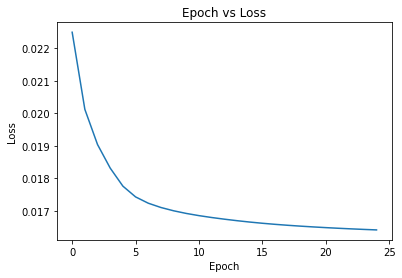

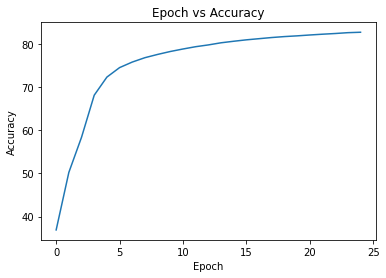

In [13]:
plt.plot(epoch_list, train_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.show()

plt.plot(epoch_list, train_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy")
plt.show()

In [14]:
test_total = 0
test_correct = 0
test_correct_list = []
test_total_list = []
y_hat_labels = []

for x, y in test_loader:
    preds = model(x)
    test_total += len(preds)

    preds_label = torch.max(preds, 1)[1]
    test_correct += (y == preds_label).sum()
    test_correct_list.append(test_correct.item())
    test_total_list.append(test_total)

    for label in preds_label:
        y_hat_labels.append(label_name(label.item()))

test_acc = sum(test_correct_list) / sum(test_total_list) * 100
print("Test Accuracy:", test_acc)

Test Accuracy: 82.1550495049505
